# Understanding Flight Delays ✈️

Flight delays are a significant challenge for both the airline and passengers, causing disruptions, financial losses, and dissatisfaction. 

Aanalyze historical flight data to uncover delay patterns, identify operational inefficiencies, and predict delays before they occur. By identifying delay patterns, predicting delays, and uncovering the factors that contribute most to delays.

These insights will help the airline make data-driven decisions to optimize scheduling, improve on-time performance, and enhance passenger satisfaction. 



In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

flight_data = pd.read_csv('data/flights.csv')
airlines_codes = pd.read_csv('data/airlines_carrier_codes.csv')
#flight_data.head()

In [2]:
#merge airlines_codes with flight_data to have full name of air line carrier
flight_data = flight_data.merge(airlines_codes, left_on='carrier', right_on = 'Carrier Code')
#drop carrier and Carrier Code
flight_data.drop(['carrier','Carrier Code'], axis = 1, inplace = True)
#change name of Airline Name to airline_name
flight_data.rename(columns={'Airline Name': 'airline_name'}, inplace=True)

In [3]:
#Create 'fligt_route'
flight_data['flight_route'] = flight_data['origin'] + '_' + flight_data['dest']
#flights without dep_time considered as canceled flights, will isolated in sperated data frame
cancled_flights = flight_data[flight_data['dep_time'].isnull()]
#drop canceled flights from fights data
flight_data = flight_data.drop(cancled_flights.index)

In [4]:
#check null
#flight_data.isnull().sum()

In [5]:
#drop remaining 1175 rows with null values as they represent a very low portition from our data
flight_data = flight_data.dropna()

In [6]:
# Create 'flight_delay' column (1 means delayed 15 Min either in departure or arrival )
flight_data['flight_delay'] = ((flight_data['dep_delay'] >= 15) | (flight_data['arr_delay'] >= 15)).astype(int)
flight_data['flight_dep_delay'] = (flight_data['dep_delay'] >= 15).astype(int)
flight_data['flight_arr_delay'] = (flight_data['arr_delay'] >= 15).astype(int)

# Create 'flight_significant_delay' column (1 means delayed more than 3 hours either in departure or arrival )
flight_data['flight_significant_delay'] = ((flight_data['dep_delay'] >= 180) | (flight_data['arr_delay'] >= 180)).astype(int)


In [7]:
# Determine which flight routes are scheduled
scheduled_routes = flight_data.groupby(['flight_route', 'month']).size().reset_index(name='count')
scheduled_routes = scheduled_routes[scheduled_routes['count'] >= 4]
scheduled_routes = scheduled_routes.groupby('flight_route').filter(lambda x: x['month'].nunique() == 12)['flight_route'].unique()

# Label flights as scheduled or irregular
flight_data['flight_type'] = flight_data['flight_route'].apply(lambda x: 'scheduled' if x in scheduled_routes else 'irregular')

In [8]:
delayed_flights = flight_data[flight_data['flight_delay'] ==1]
dep_delay_and_arr_delay = ((delayed_flights['flight_dep_delay'] == 1) & (delayed_flights['flight_arr_delay'] == 1)).mean()
dep_on_time_and_arr_delay = ((delayed_flights['flight_dep_delay'] == 0) & (delayed_flights['flight_arr_delay'] == 1)).mean()
dep_delay_and_arr_on_time = ((delayed_flights['flight_dep_delay'] == 1) & (delayed_flights['flight_arr_delay'] == 0)).mean()

# 🎯 Key Finding
1. ✈️ Flight Delay Statistics – Insights from the Data

    - **61.15 %** of flights that experienced a departure delay also arrived late.
    - **15.37 %** of flights were delayed at departure but still managed to arrive on time.
    - **23.48 %** of flights that departed on time ended up arriving late.
    
So it's important to foucs on decreasing number of flights delayed at departure airport.

2.  🚨 **1.38%** of Flights Experienced Severe Delays (Over 3 Hours)

    - While this may seem like a small percentage, severe delays can result in significant financial losses, especially if the causes are attributable to airline-related issues such as operational inefficiencies, maintenance problems, or crew shortages.

    - These delays may trigger compensation obligations, increased passenger dissatisfaction, and disruption to the entire flight schedule, magnifying their impact across the network

3. **22.12%** of flights departing from NYC airports experienced delays, with the average delay lasting approximately 65 minutes.
4. Atlanta (ATL) is the top destination, receiving the highest number of flights **16,898** (flight each **31** minutes)
5. Out of **104** destination airports, **82** airports maintained a consistent schedule.The remaining **22** airports experienced irregular flight traffic.
6. **Hawaiian Airlines** operated **342** flights without any cancellations.
7. **ExpressJet Airlines** offers the widest coverage across the U.S. from New York City, serving 61 destinations. However, it also holds the highest cancellation rate among all carriers, with approximately **5.51%** of its flights—**2,817** out of **51,108**—being canceled.
8. Delayed and canceled flights Heatmap at 2023 shows
 - July experienced the highest delay rate at **30.19%** due to weather condition [source](https://www.cnbc.com/2023/06/30/july-fourth-holiday-flight-disruptions.html), while September saw the lowest delay rate at **14.29%**.
 - February had the highest cancellation rate at **15.28%**, whereas November had the lowest cancellation rate at **2.82%**.
 - High cancelation rate at February warrants further investigation, as no significant evidence of bad weather has been found to explain the spike

9. Based on your flight data, the GradientBoostingClassifier model can predict whether your flight will experience a departure delay, achieving an accuracy of **78.82%**.

![departure](departure.jpg)


# 🔎 Data Overview
1. We have three origin for our flights, these airports are serving New York City 
    - JFK : John F. Kennedy Airport - New York (International)
    - EWR : Newark Liberty Airport - New Jersey (International)
    - LGA : LaGuardia Airport - New York (domestic)

2. Flights are landing on 104 destination inside USA or its territories (like Puerto Rico and the U.S. Virgin Islands). 

3. In the United States, the definition of a flight delay varies depending on the context:​

    - **Federal Aviation Administration (FAA)**: Considers a flight delayed if it departs or arrives 15 minutes or more after its scheduled time. ​

    - **U.S. Department of Transportation (DOT)**: 
      -  Defines a "significant delay" as a delay of 3 hours or more for domestic flights and 6 hours or more for international flights. Such significant delays may entitle passengers to compensation or refunds.
      - Airlines are not required by law to compensate passengers for flight cancellations if the reason is out of their control.
      - However, if the cancellation is due to a reason within the airline’s control (e.g., staffing, mechanical issues), most airlines offer compensation or rebooking options

4. Data cleaning
    - A total of 8,255 flights lacked departure time information, which likely indicates cancellations due to weather disruptions or other operational issues. These records were segregated for focused analysis on cancellations.

    - Additionally, 458 flights were missing arrival time, and 717 records lacked both air time and arrival delay. Since these represented a very small portion of the dataset, we removed them to maintain data integrity without significantly impacting the analysis.

# 🛫⏳ Departure Airport delay
Newark Liberty International Airport (EWR) emerged as the busiest among the three major New York airports, handling a total of 117,596 departure flights, out of which 29,775 flights were delayed. It was followed by John F. Kennedy International Airport (JFK), which recorded 109,416 total departure flights with 23,347 delays. LaGuardia Airport (LGA) had the lowest traffic volume, with 101,509 total departure flights and 19,792 delayed flights.

Delayed flights has on average about one hour delay

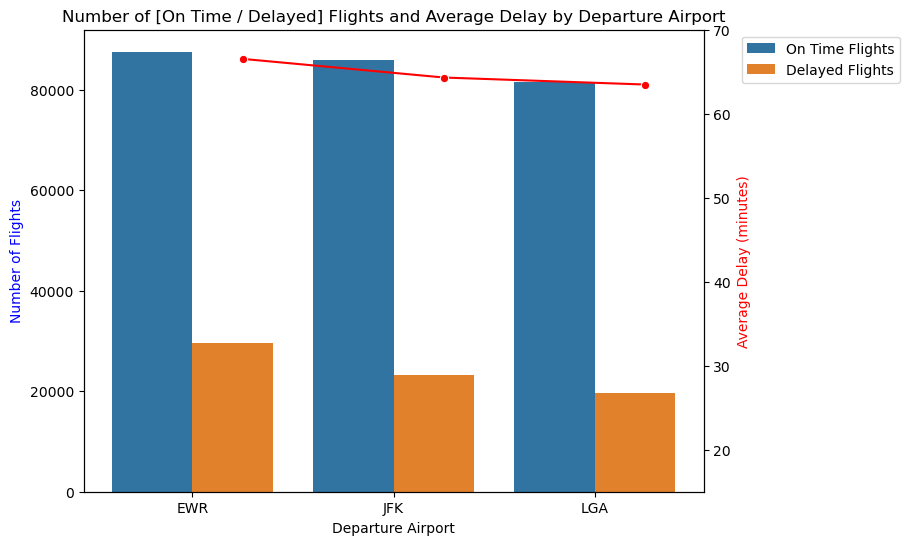

In [9]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the count of flights for each carrier using a count plot
sns.countplot(data=flight_data, x='origin', ax=ax1, order=flight_data['origin'].value_counts().index, hue='flight_dep_delay')
ax1.set_ylabel('Number of Flights', color='b')
ax1.set_xlabel('Departure Airport')
ax1.grid(False)  # Remove grid from ax1

# Update legend labels
handles, labels = ax1.get_legend_handles_labels()
labels = ['On Time Flights' if label == '0' else 'Delayed Flights' for label in labels]
ax1.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# Create a second y-axis to plot the average delay
ax2 = ax1.twinx()
avg_delay_per_origin = flight_data[flight_data['flight_dep_delay'] == 1].groupby('origin')['dep_delay'].mean().sort_values(ascending=False)

# Adjust the x positions to be in the center of the delayed column
delayed_positions = [i + 0.25 for i in range(len(avg_delay_per_origin))]

sns.lineplot(x=delayed_positions, y=avg_delay_per_origin.values, ax=ax2, color='r', marker='o')
ax2.set_ylabel('Average Delay (minutes)', color='r')
ax2.set_ylim(15, 70)  # Start y-axis from 0
ax2.grid(False)  # Remove grid from ax2

# Set the title of the plot
plt.title('Number of [On Time / Delayed] Flights and Average Delay by Departure Airport')

plt.show()

At Newark Liberty International Airport (EWR), the volume of air traffic is striking:

On average, **322** flights depart every single day, highlighting the airport’s constant activity.

That’s roughly **13.5** flights taking off every hour—or a departure approximately every **4.5** minutes.

# 🛬⏳ Delays at Destination: A Look into Arrival Airport Performance

## Frequent Flights Destination

The data reveals flights from New York City airports cover a wide network of 104 unique destinations across the U.S.

- Atlanta (ATL) is the top destination, receiving the highest number of flights at 16,898, followed closely by Chicago O’Hare (ORD) with 16,642, and Los Angeles (LAX) with 16,076 flights.

- On the other end of the spectrum, some destinations receive only a handful of flights annually:

    - Lexington (LEX) had just 1 flight,
    - Anchorage (ANC) received 8 flights,
    - South Bend (SBN) recorded 10 flights for the year.

This highlights both the scale and diversity of flight distribution from NYC airports—ranging from major hubs with constant traffic to niche routes serving specific regional demands.

In [10]:
#destination airports with lowest number of flights from NYC
#flight_data['dest'].value_counts().nsmallest(10)

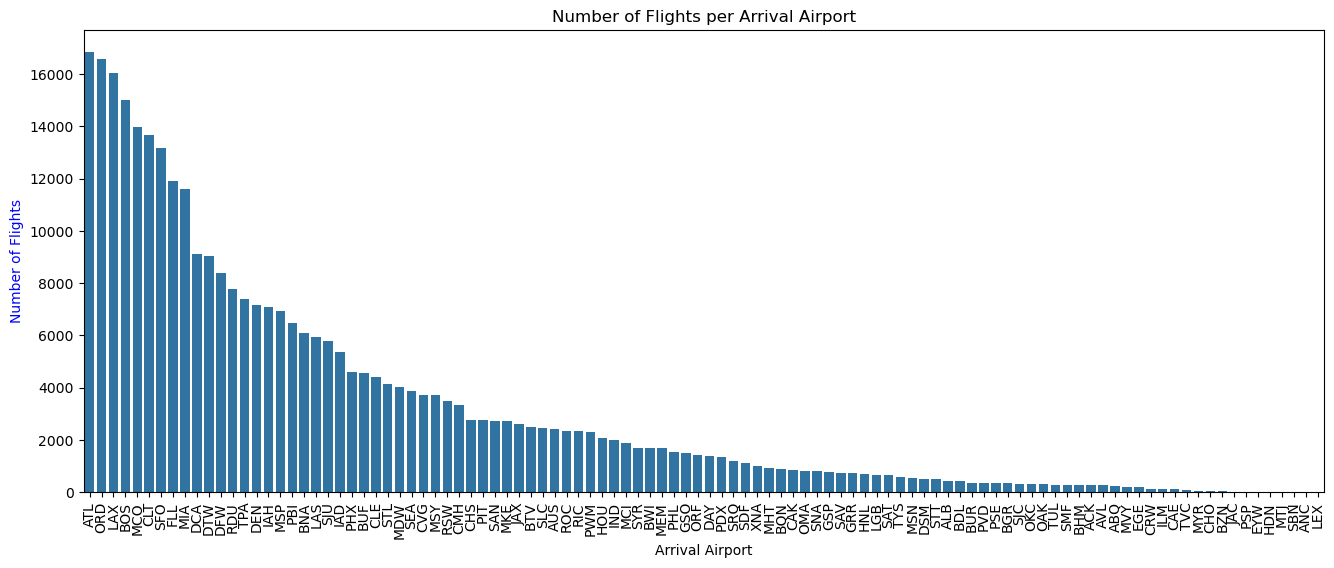

In [11]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot the count of flights for each carrier using a count plot
sns.countplot(data=flight_data, x='dest', ax=ax1, order=flight_data['dest'].value_counts().index)
ax1.set_ylabel('Number of Flights', color='b')
ax1.set_xlabel('Arrival Airport')
plt.title('Number of Flights per Arrival Airport')
plt.xticks(rotation=90);

# Create a second y-axis to plot the average delay
# ax2 = ax1.twinx()
# avg_delay_per_carrier = flight_data[flight_data['flight_arr_delay'] == 1].groupby('dest')['arr_delay'].mean().sort_values(ascending=False)
# sns.lineplot(x=avg_delay_per_carrier.index, y=avg_delay_per_carrier.values, ax=ax2, color='r', marker='o')
# ax2.set_ylabel('Average Delay (minutes)', color='r')
# ax2.axhline(15, color='black', linestyle='--')  # Corrected line
# ax2.set_ylim(-20, 100)
# plt.title('Number of Flights and Average Arrival Delay per Airport')
# plt.show()

## Flights Arrival Delay
On average delay arrival time is the same regardless the count of flight that airport receive

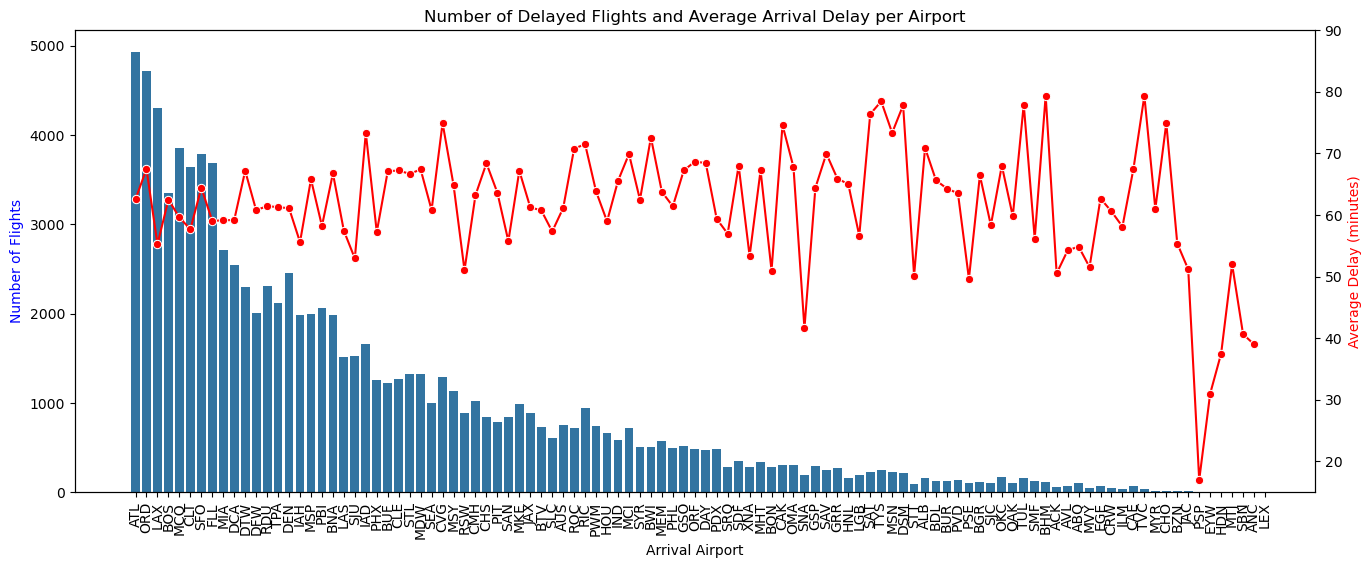

In [12]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot the count of flights for each carrier using a count plot
sns.countplot(data=delayed_flights, x='dest', ax=ax1, order=flight_data['dest'].value_counts().index)
ax1.set_ylabel('Number of Flights', color='b')
ax1.set_xlabel('Arrival Airport')
plt.xticks(rotation=90)

# Create a second y-axis to plot the average delay
ax2 = ax1.twinx()
avg_delay_per_carrier = flight_data[flight_data['flight_arr_delay'] == 1].groupby('dest')['arr_delay'].mean().sort_values(ascending=False)
sns.lineplot(x=avg_delay_per_carrier.index, y=avg_delay_per_carrier.values, ax=ax2, color='r', marker='o')
ax2.set_ylabel('Average Delay (minutes)', color='r')
#ax2.axhline(15, color='black', linestyle='--')  # Corrected line
ax2.set_ylim(15, 90)
plt.title('Number of Delayed Flights and Average Arrival Delay per Airport')
plt.show()

Airports that recorded low flight counts from NYC, it's highly likely that these were non-regular, possibly chartered or private flights rather than part of a scheduled commercial service.

Some possible reasons:

✈️ Private business or government travel

🌲 Seasonal or special events

🚫 Discontinued or test routes

🧑‍💼 Corporate or VIP trips

These routes typically don’t appear in regular flight schedules and may have been operated on-demand based on specific needs.

## Most Delayed Arrival Airports
Tulsa International Airport  (TUL) recorded the highest average arrival delay at 72.5 minutes.

However, this does not necessarily reflect poor performance at TUL itself. The data shows that the average delay for flights departing to TUL already begins delayed at the origin airport, with an average departure delay of 68.4 minutes. 
This suggests that the majority of the delay occurs before the flight even leaves, rather than being caused by operations at Tulsa International Airport.

In [13]:
dest_airport_delayed = delayed_flights.groupby('dest')['arr_delay'].mean().sort_values().nlargest(20).reset_index(name='arrival_delay')
#dest_airport_delayed

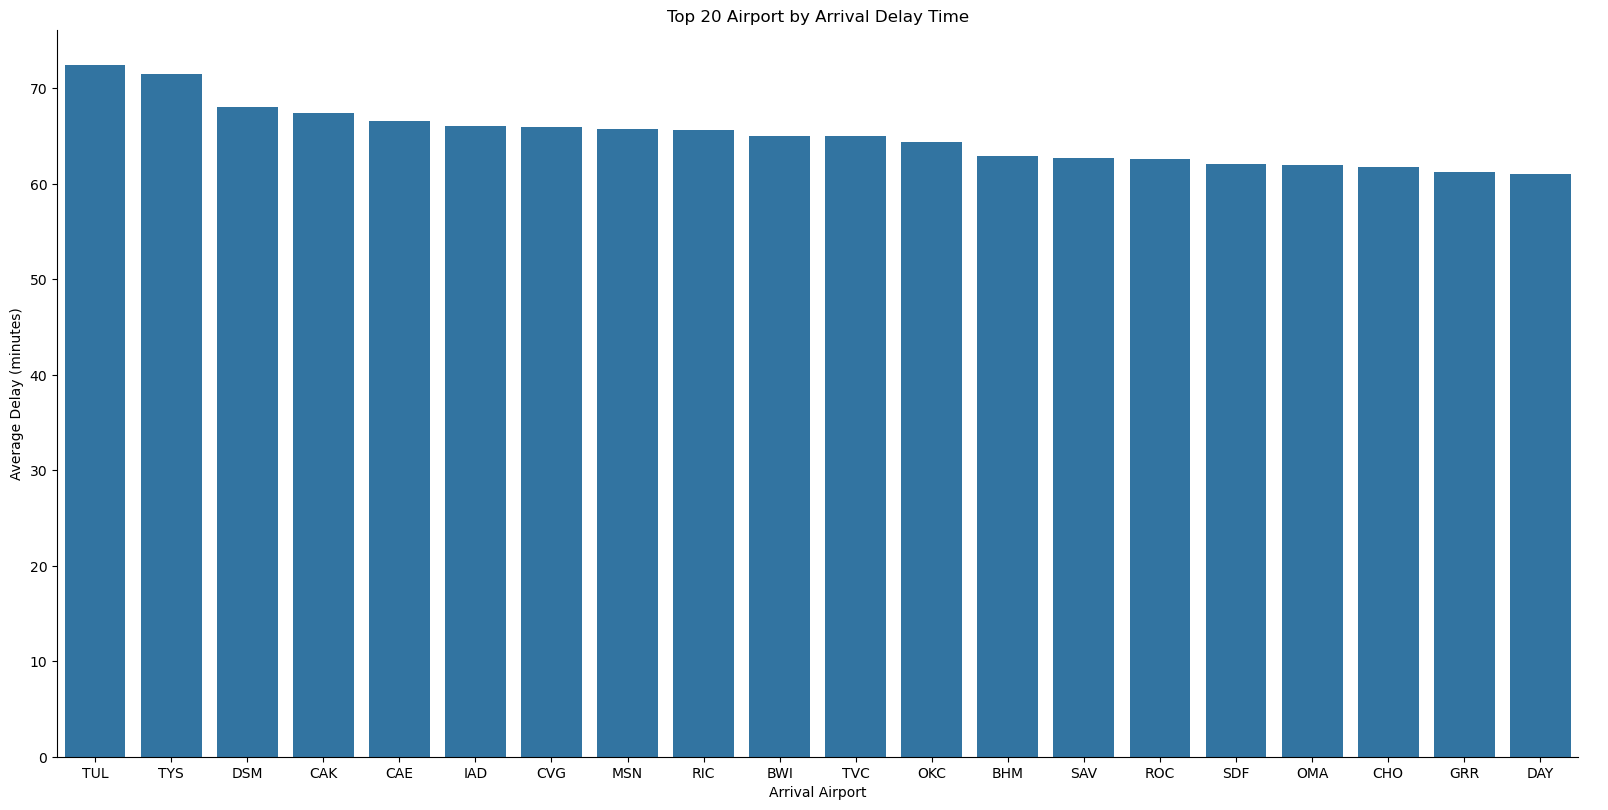

In [14]:
#plt.figure(figsize=[18, 6])

sns.catplot(data=dest_airport_delayed, x='dest', y='arrival_delay', kind='bar', height=8, aspect=2)
plt.title('Top 20 Airport by Arrival Delay Time')
plt.xlabel('Arrival Airport')
plt.ylabel('Average Delay (minutes)');

In [15]:
#check average delay for delayed flights for destination airport
#delayed_flights[delayed_flights['dest'] == 'CHO']['dep_delay'].mean()

# 🗓️ Scheduled vs. Irregular Flights: Uncovering Patterns in Air Traffic Operations
- Out of 104 destination airports, 82 airports maintained a consistent schedule, receiving at least one flight per week throughout the year — reflecting stable, regular air traffic patterns.

- The remaining 22 airports experienced irregular flight traffic, with flights occurring seasonally or tied to specific events, indicating a more demand-driven or occasional service model.

In [16]:
# Determine which flight routes are scheduled
scheduled_routes = flight_data.groupby(['flight_route', 'month']).size().reset_index(name='count')
scheduled_routes = scheduled_routes[scheduled_routes['count'] >= 4]
scheduled_routes = scheduled_routes.groupby('flight_route').filter(lambda x: x['month'].nunique() == 12)['flight_route'].unique()

# Label flights as scheduled or irregular
flight_data['flight_type'] = flight_data['flight_route'].apply(lambda x: 'scheduled' if x in scheduled_routes else 'irregular')

In [17]:
#Number of airports with scheduled flights
#flight_data[flight_data['flight_type'] == 'scheduled']['dest'].nunique()

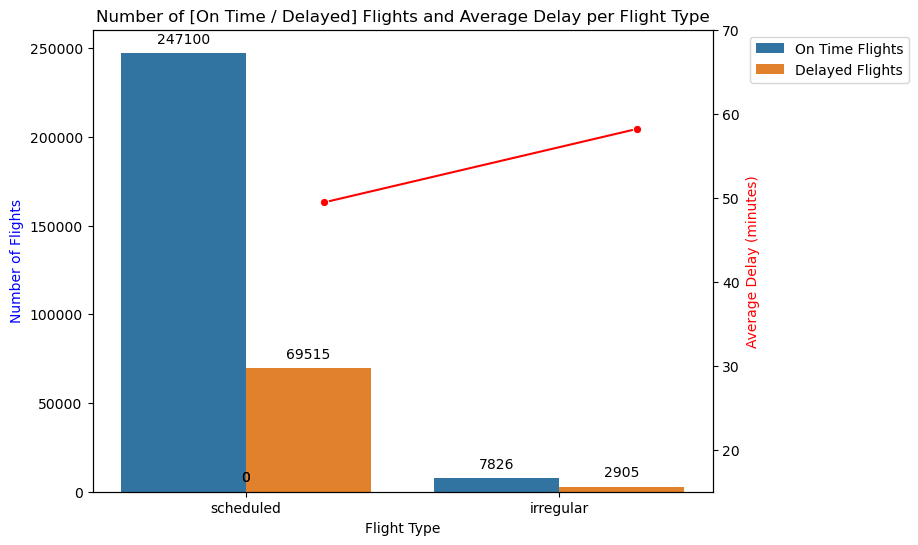

In [18]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the count of flights for each carrier using a count plot
sns.countplot(data=flight_data, x='flight_type', ax=ax1, order=flight_data['flight_type'].value_counts().index, hue='flight_dep_delay')
ax1.set_ylim(0, ax1.get_ylim()[1]+1000) 
ax1.set_ylabel('Number of Flights', color='b')
ax1.set_xlabel('Flight Type')
ax1.grid(False)  # Remove grid from ax1

# Add value labels on the bars
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Update legend labels
handles, labels = ax1.get_legend_handles_labels()
labels = ['On Time Flights' if label == '0' else 'Delayed Flights' for label in labels]
ax1.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# Create a second y-axis to plot the average delay
ax2 = ax1.twinx()

# Calculate average delay per flight type
avg_delay_per_flight_type = delayed_flights.groupby('flight_type')['dep_delay'].mean()

# Adjust the x positions to be in the center of the delayed column
delayed_positions = [i + 0.25 for i in range(len(avg_delay_per_flight_type))]

# Plot the average delay on the second y-axis
sns.lineplot(x=delayed_positions, y=avg_delay_per_flight_type.sort_values(ascending=True).values, ax=ax2, color='r', marker='o')
ax2.set_ylabel('Average Delay (minutes)', color='r')
ax2.grid(False)  # Remove grid from ax2
ax2.set_ylim(15, 70)  # Set y-axis to start from zero

plt.title('Number of [On Time / Delayed] Flights and Average Delay per Flight Type')
plt.show()

In [19]:
#dep delay for flights to CAE airport
#flight_data[flight_data['dest'] == flight_data.groupby('dest')['arr_delay'].mean().sort_values().idxmax()]['dep_delay'].mean()

# 📊 Flight Route Performance — Top 50 Routes by Volume and Average Arrival Delay

1. High Volume, Low Delay:

    - Routes like JFK → LAX (11159) flight per year -- 30 flight per day, 1 flight every 47 minutes.

    - Despite high traffic, average arrival delays remain moderate, suggesting efficient operations on these busy routes.

2. Low Volume, High Delay:

    - Routes towards the right end, such as EWR → STL and EWR → CVG have fewer flights but relatively higher delays.

    - This might indicate irregular scheduling air traffic control, or gate availability.

In [20]:
#flight_data.groupby('flight_route')['flight_route'].count().sort_values(ascending=False)

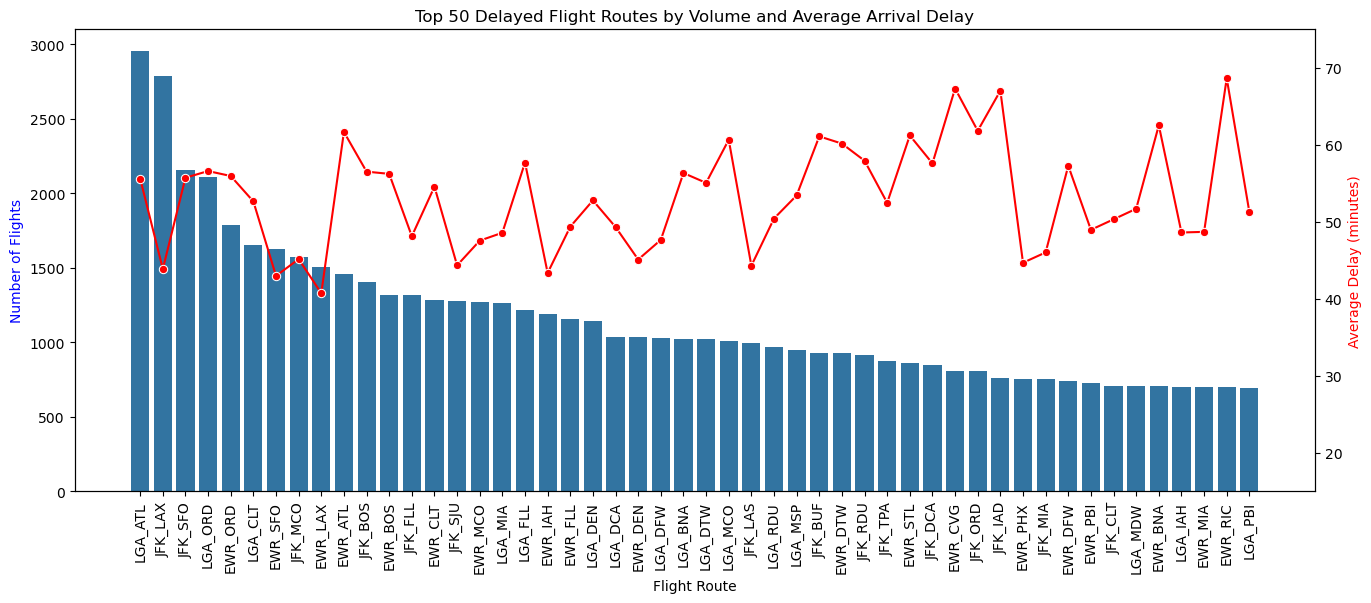

In [21]:

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(16, 6))

# Select the first 50 flight routes
top_50_routes = delayed_flights['flight_route'].value_counts().index[:50]

# Filter the data to include only the top 50 flight routes
filtered_flight_data = delayed_flights[delayed_flights['flight_route'].isin(top_50_routes)]

# Plot the count of flights for each of the top 50 flight routes using a count plot
sns.countplot(data=filtered_flight_data, x='flight_route', ax=ax1, order=top_50_routes)
ax1.set_ylabel('Number of Flights', color='b')
ax1.set_xlabel('Flight Route')
plt.xticks(rotation=90)

# Create a second y-axis to plot the average delay
ax2 = ax1.twinx()
avg_delay_per_route = filtered_flight_data.groupby('flight_route')['arr_delay'].mean().sort_values(ascending=False)
sns.lineplot(x=avg_delay_per_route.index, y=avg_delay_per_route.values, ax=ax2, color='r', marker='o')
ax2.set_ylabel('Average Delay (minutes)', color='r')
ax2.set_ylim(15, 75)  # Start y-axis from 10

# Add title to the plot
plt.title('Top 50 Delayed Flight Routes by Volume and Average Arrival Delay')

plt.show()

# ✈️ Airline Flight Volume and Avergare Delay

- United Airlines Inc. operates the highest number of flights among all carriers, maintaining an impressive average delay of under 5 minutes, indicating efficient operational performance.

- In contrast, ExpressJet Airlines Inc., despite being among the top 3 airlines in terms of flight volume, reports an average departure delay exceeding 15 minutes, highlighting potential scheduling or operational challenges.

- Smaller airlines exhibit a high degree of variation in delay times, suggesting that limited resources or less frequent scheduling may contribute to inconsistent performance.


In [22]:
#flight_data['airline_name'].value_counts()

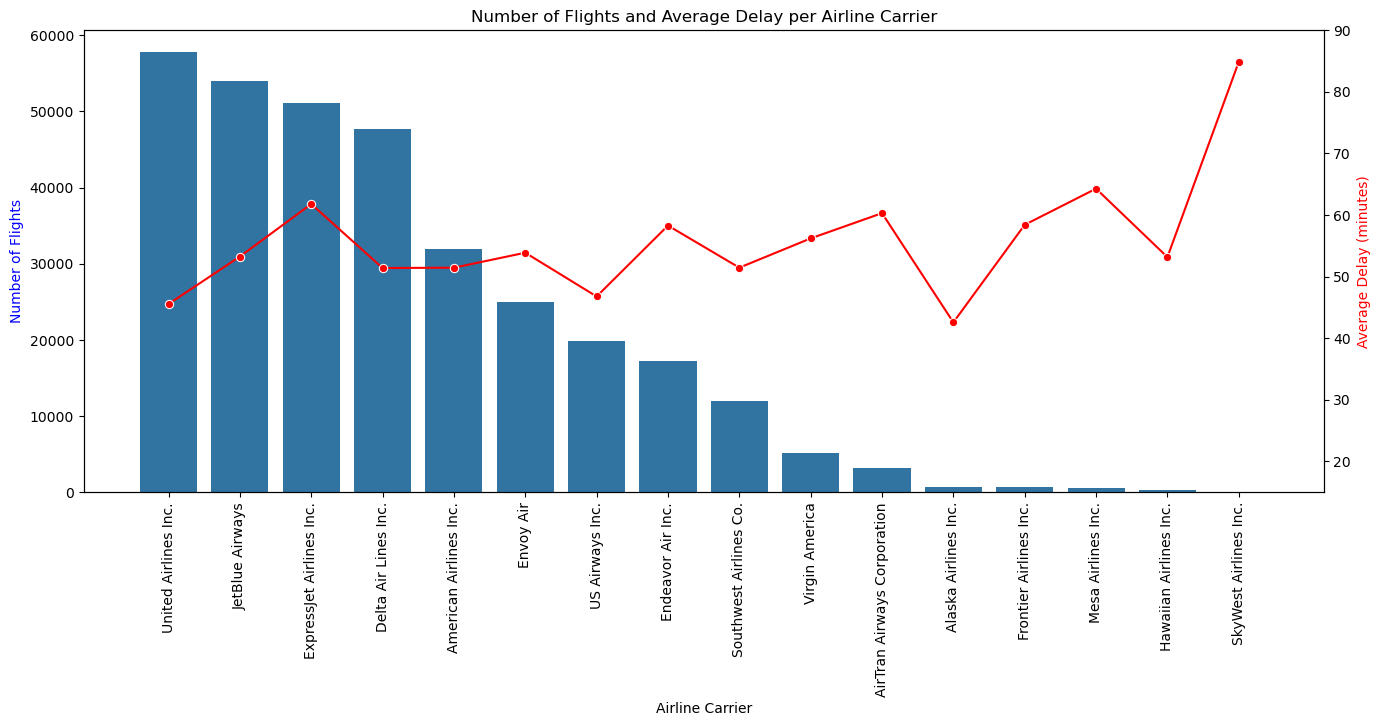

In [23]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot the count of flights for each carrier using a count plot
sns.countplot(data=flight_data, x='airline_name', ax=ax1, order=flight_data['airline_name'].value_counts().index)
ax1.set_ylabel('Number of Flights', color='b')
ax1.set_xlabel('Airline Carrier')
#plt.title('Number of Flights per Airline Carrier')
plt.xticks(rotation=90)

#Create a second y-axis to plot the average delay
ax2 = ax1.twinx()
avg_delay_per_carrier = delayed_flights.groupby('airline_name')['arr_delay'].mean().sort_values(ascending=False)
sns.lineplot(x=avg_delay_per_carrier.index, y=avg_delay_per_carrier.values, ax=ax2, color='r', marker='o')
ax2.set_ylabel('Average Delay (minutes)', color='r')
ax2.set_ylim(15,90)
#ax2.axhline(15, color='black', linestyle='--')  # Corrected line
plt.title('Number of Flights and Average Delay per Airline Carrier')
plt.show()

## Airlines Destinations 
- ExpressJet Airlines serves 61 destinations, outperforming United Airlines, which—despite operating a higher number of flights—covers only 47 destinations, 14 fewer than ExpressJet.
- Hawaiian Airlines, Alaska Airlines and Frontier Airlines are serving only one destination

In [24]:
# Number of destinations that airlinr cover
#flight_data.groupby(['airline_name','dest']).size().reset_index()['airline_name'].value_counts()

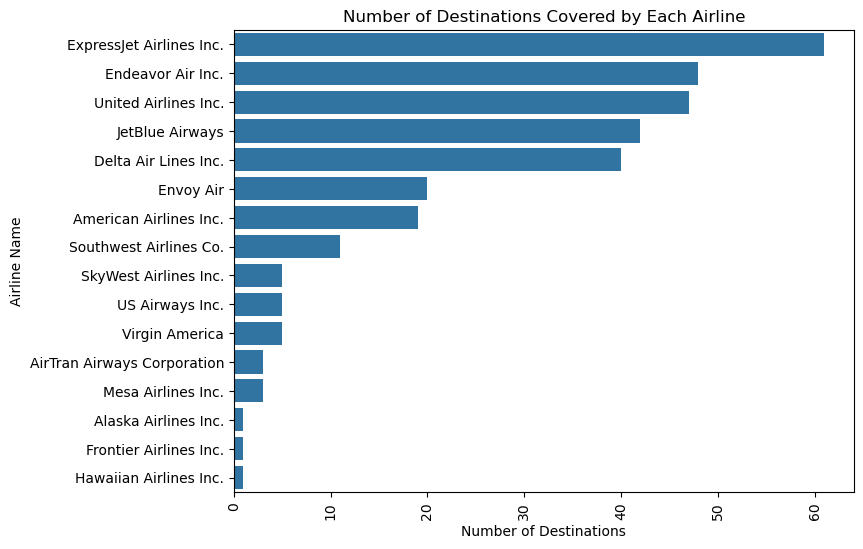

In [25]:
# Number of destinations that airline cover
plt.figure(figsize = [8,6])
number_of_airline_dest = flight_data.groupby(['airline_name','dest']).size().reset_index()['airline_name'].value_counts()
sns.barplot(y=number_of_airline_dest.index, x=number_of_airline_dest.values)
plt.xticks(rotation = 90)
plt.xlabel('Number of Destinations')
plt.ylabel('Airline Name')
plt.title('Number of Destinations Covered by Each Airline')
plt.show()

## Canceled Flights for Airlines
- ExpressJet Airlines recorded the highest number of canceled and delayed flights in 2023, with 2,817 cancellations out of 51,108 flights, significantly higher than United Airlines, which had only 686 cancellations across 57,782 flights.

- Envoy Air ranked second in cancellations, with 1,234 canceled flights, despite operating a relatively modest 25,037 flights and serving only 20 destinations.

- Endeavor Air ranked third in with 1044 canceled flights, it serves a wider network of 48 destinations while operating a lower volume of 17,294 flights, indicating a broader reach with fewer total operations.

In [26]:
count_canceled = cancled_flights['airline_name'].value_counts().rename('count_canceled').reset_index()
count_delayed = delayed_flights['airline_name'].value_counts().rename('count_delayed').reset_index()


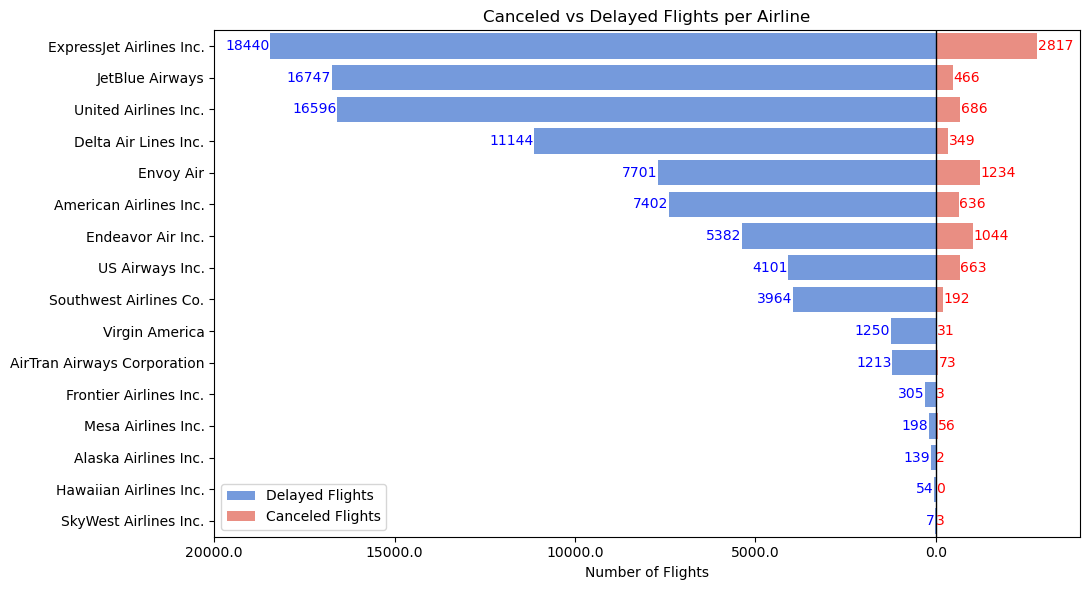

In [27]:
# Merge on airline_name
df = pd.merge(count_canceled, count_delayed, on='airline_name', how='right')
df = df.sort_values('count_delayed', ascending=True).reset_index(drop=True)
df = df[::-1]  # For better visual top-down layout

# Handle NaN values by filling them with 0
df['count_canceled'] = df['count_canceled'].fillna(0).astype(int)
df['count_delayed'] = df['count_delayed'].fillna(0)

# Set Seaborn style
#sns.set(style="whitegrid")

# Plot
fig, ax = plt.subplots(figsize=(11, 6))

# Barplot for delayed flights (left side, negated)
sns.barplot(x=[-x for x in df['count_delayed']], y=df['airline_name'],
            color='cornflowerblue', label='Delayed Flights', ax=ax)

# Barplot for canceled flights (right side)
sns.barplot(x=df['count_canceled'].astype(int), y=df['airline_name'],
            color='salmon', label='Canceled Flights', ax=ax)

# Add value labels
for i in range(len(df)):
    ax.text(-df['count_delayed'].iloc[i] - 10, i,
            df['count_delayed'].iloc[i], ha='right', va='center', color='blue')
    ax.text(df['count_canceled'].iloc[i] + 10, i,
            df['count_canceled'].iloc[i], ha='left', va='center', color='red')

# Axis formatting
ax.axvline(0, color='black', lw=1)
#ax.set_xticks(range(-max(df['count_delayed']) - 100, max(df['count_canceled']) + 200, 500))
ax.set_xticklabels([abs(x) for x in ax.get_xticks()])
ax.set_xlim(-20000, 4000)
ax.set_xlabel('Number of Flights')
ax.set_ylabel('')
ax.set_title('Canceled vs Delayed Flights per Airline')
ax.legend(loc='lower left')
#ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Comparing the **Top 3** Airline carrier we noticed 
- ExpressJet Airlines Inc. stands out with the highest number of delayed and canceled flights, yet it also covers the most destinations, indicating a broad but possibly overextended operational network.

- United Airlines Inc. operates the largest volume of flights, but across a more limited number of routes. Interestingly, it maintains the lowest delay rate, highlighting efficient route management.

- JetBlue Airways follows a similar strategic approach to United, focusing on fewer cancellations and demonstrating strong performance with the lowest cancellation rate among the top carriers.

In [28]:
#cancled_flights['airline_name'].value_counts()

## Overall Relationship

- More destinations don’t guarantee fewer cancellations. ExpressJet serves the most destinations but also leads in cancellations (5.5% of it filghts).

- Higher flight volume with fewer destinations (like United) may benefit from centralized operations and better reliability.

- Airlines with fewer destinations and flights (like Envoy and Endeavor) can still face high cancellation rates, suggesting that operational quality, not just scale, influences reliability.

In [29]:
carrier_max_canceled_name = cancled_flights['airline_name'].value_counts().idxmax()
carrier_max_canceled_value = cancled_flights['airline_name'].value_counts().max()
#carrier_max_canceled_value / flight_data[flight_data['airline_name'] == carrier_max_canceled_name].shape[0]

# 📊 Monthly Departure Delay Trends Across NYC Airports at 2023

- All three airports — JFK, LGA, and EWR — show a noticeable spike in departure delays during the summer months (June to August), with JFK peaking in July at the highest delay.

- Departure delays drop significantly in September through November, hitting the lowest in October and November across all airports, indicating more stable operations in fall.


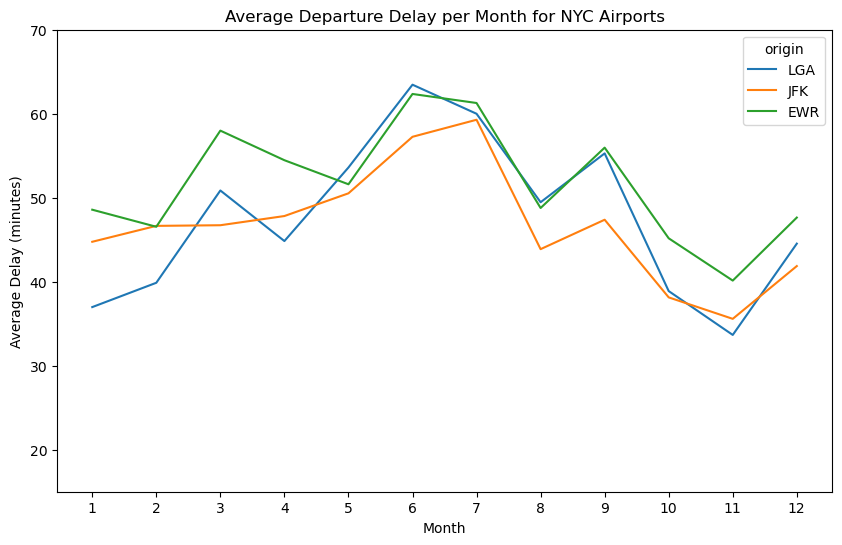

In [30]:
plt.figure(figsize = [10,6])
sns.lineplot(data = delayed_flights, x = 'month', y = 'dep_delay', ci = None, hue = 'origin')
plt.ylim(15, 70)  # Start y-axis from 10
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Month')
plt.title('Average Departure Delay per Month for NYC Airports')
plt.xticks(ticks=range(1, 13));

## Tracking Daily Flight Delays: Heat Map of Delayed Departures
A closer look at daily flight delays throughout 2023—visualized via a heatmap—reveals key patterns. Darker cells indicate days with a high volume of delays, serving as clear signals for further investigation.

These peaks could point to underlying issues such as severe weather, operational disruptions, or seasonal travel surges that warrant deeper analysis.

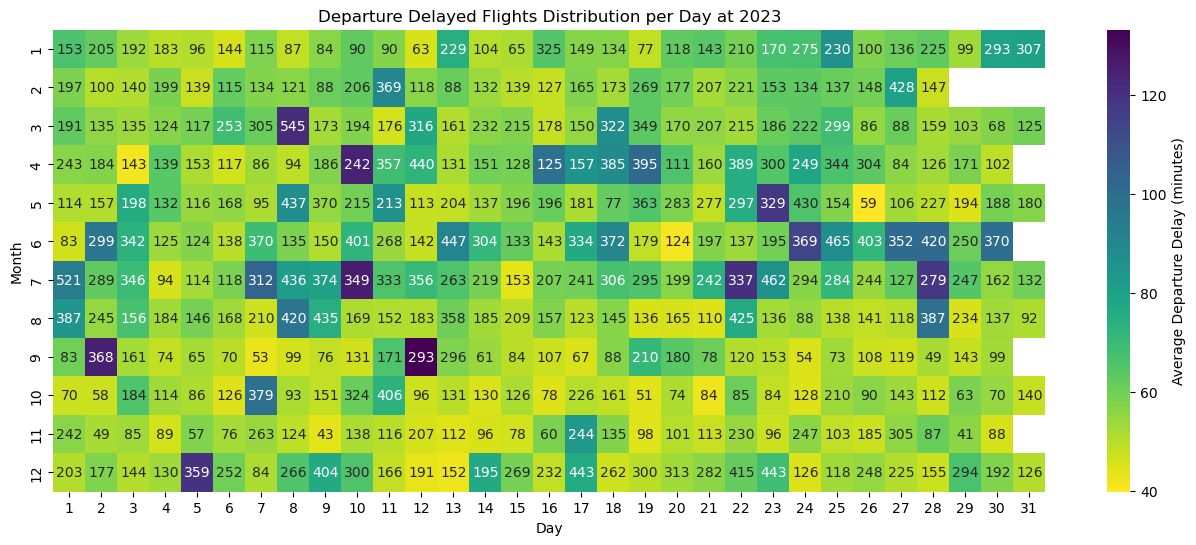

In [31]:
# Create a pivot table to use as the data for the heatmap
dep_delay_pivot_table = flight_data[flight_data['dep_delay'] > 15].pivot_table(index="month", columns="day", values="dep_delay", aggfunc='mean')

# Create a pivot table to use for annotations representing the count of flights
count_pivot_table = flight_data[flight_data['dep_delay'] > 15].pivot_table(index="month", columns="day", values="dep_delay", aggfunc='count')

# Plot the heatmap using the pivot table with a reversed color palette and annotating the count of flights
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data=dep_delay_pivot_table, cmap='viridis_r', annot=count_pivot_table, fmt=".0f", cbar_kws={'label': 'Average Departure Delay (minutes)'})
plt.title('Departure Delayed Flights Distribution per Day at 2023')
plt.xlabel('Day')
plt.ylabel('Month');

By quick search on web
- June experienced a surge in long delays, primarily due to frequent thunderstorms disrupting flight schedules.

- July saw extended delays caused by multiple rounds of heavy rainfall, impacting operations over several days.

- In September, 2 days delay appeared again, correlating with intense rainfall events.

- October continued the trend, with persistent heavy rainfall contributing to elevated delay times.

- December was marked by storms and widespread rain, leading to a notable increase in long delays, particularly around the holiday travel period.

These findings highlight how seasonal weather patterns, especially in summer and winter, have a significant impact on flight punctuality.

## Understanding Flight Cancellations and Delays: A Head-to-Head Comparison

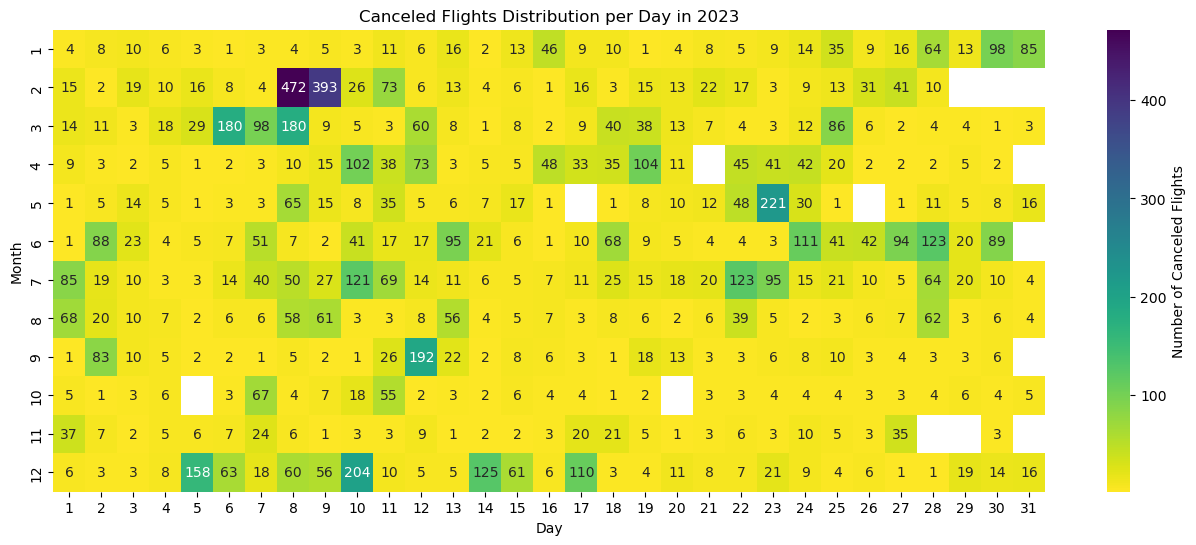

In [32]:
# Create a pivot table to use as the data for the heatmap
cancled_pivot_table = cancled_flights.pivot_table(index="month", columns="day", values="sched_dep_time", aggfunc='count')

# Create a pivot table to use for annotations representing the count of flights
count_canceled_pivot_table = cancled_flights.pivot_table(index="month", columns="day", values="sched_dep_time", aggfunc='count')

# Plot the heatmap using the pivot table with a reversed color palette and annotating the count of flights
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data=cancled_pivot_table, cmap='viridis_r', annot=count_canceled_pivot_table, fmt=".0f", cbar_kws={'label': 'Number of Canceled Flights'})
plt.title('Canceled Flights Distribution per Day in 2023')
plt.xlabel('Day')
plt.ylabel('Month');

By comparing the flight cancellation map with the delay map, a clear correlation emerges — days with a high volume of delayed flights often coincide with a notable increase in cancellations. This pattern suggests frequently escalates into flight cancellations.

**However**, there's a notable exception on February 8 and 9. During these two days:

- The number of cancelled flights surged dramatically, despite the overall delay levels remaining within normal averages.

- This anomaly indicates that cancellations may have been driven by non-delay-related factors, such as weather warnings, staffing issues, or ground operations disruptions.

In [33]:
#cancled_flights[(cancled_flights['month'] == 2) & ((cancled_flights['day'] == 8) | (cancled_flights['day'] == 9))]['origin'].value_counts()

## Investigating the Drop in Flight Volume – February 2023
Upon examining the flight data for February 2023, there's a notable drop in the total number of recorded flights from all departure airports on February 8 and 9.

Is the drop a result of incomplete or missing data entries, where flights were not logged or erroneously excluded?
Or does it reflect a real operational impact, such as an increase in cancellations, weather-related disruptions, or air traffic control limitations?

Only by verifying both data integrity and external operational factors can we confirm whether this decline reflects a real-world disruption or a data reporting artifact.

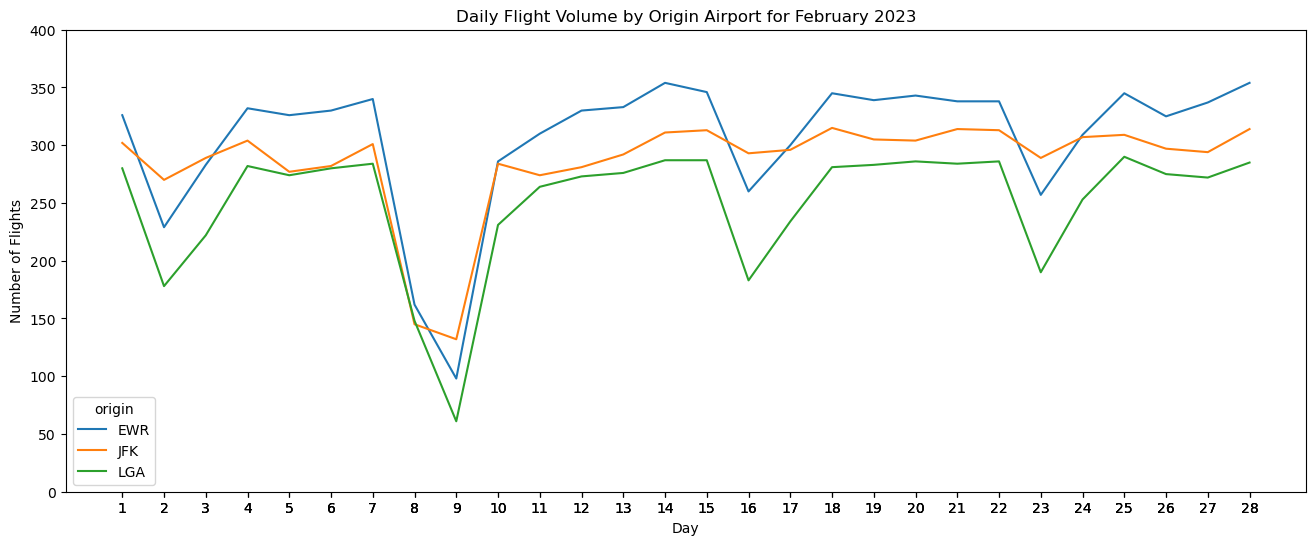

In [34]:
plt.figure(figsize=(16,6))
feb_flights = flight_data[flight_data['month'] == 2].groupby(['day', 'origin']).size().reset_index(name='Count of Flights')
sns.lineplot(data=feb_flights, x='day', y='Count of Flights', hue = 'origin')
plt.xticks(ticks=feb_flights['day'])
plt.ylim(0, 400)  # Start y-axis from 0
plt.xlabel('Day')
plt.ylabel('Number of Flights')
plt.title('Daily Flight Volume by Origin Airport for February 2023');

# 🤖 Developing a Model to Forecast Flight Departure Delays

Based on 2023 flight data, we will build a predictive model to determine whether a flight will be delayed, using only ticket-related details.

To ensure the model reflects real-world prediction scenarios, we will take the following preprocessing steps:

- Exclude actual flight timing data, such as `dep_time`, `dep_delay`, `arr_time`, and `arr_delay`, to avoid data leakage.

- Remove the `tailnum` column, as it provides limited predictive value and may introduce unnecessary noise.

- Engineer a new feature by extracting the week number of the year, which can help capture seasonal trends in delays.

- Apply label encoding to categorical columns, including `origin`, `dest`, `airline_name`, and `flight_type`, to make them suitable for machine learning algorithms.

In [35]:
flight_model = flight_data.copy()
#flight_model.head()

In [36]:
# Add week number to the data
# Combine month and day into a single 'date' column to calculate the week number
flight_model['date'] = pd.to_datetime(flight_model[['month', 'day']].assign(year=2023))  # Assuming year 2023

# Get the week number
flight_model['week_number'] = flight_model['date'].dt.isocalendar().week


In [37]:
#Reomve unneeded data id, year (all deata for same year), tailnum
#Remove data that indicates flight delay (dep_delay, arr_delay, flight_dealy, flight_arr_delay, flight_significant_delay)
#Remove flight_route as origin and destination are exist, 
flight_model = flight_model.drop(['id', 'year','dep_time','dep_delay','tailnum', 'flight_route', 'arr_time','flight_delay', 'flight_arr_delay',
                                  'flight_significant_delay', 'arr_delay', 'date'], axis = 1)

In [38]:
#label encoding for categorical variable
from sklearn.preprocessing import LabelEncoder

#splitting
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#handling implance
from imblearn.over_sampling import SMOTE

In [39]:
y = flight_model['flight_dep_delay']
X = flight_model.drop('flight_dep_delay', axis = 1)

In [40]:
#X.columns

In [41]:
#split_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [42]:
#labeling job_category and company_sub_region 
for col in ['origin', 'dest', 'airline_name', 'flight_type']:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col]) +1
    X_test[col] = le.transform(X_test[col]) +1

Understanding feature importance in our model reveals that `day`, `air_time`, and `week_number` are the most influential variables in predicting flight delays

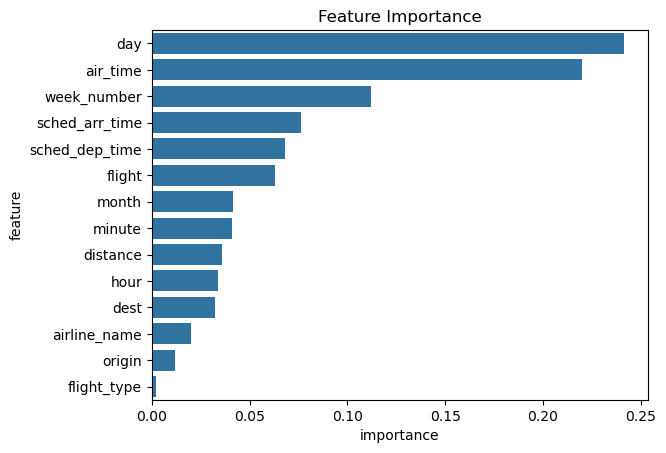

In [43]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame(
    {'feature': X_train.columns, 'importance': feature_importances}
)

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(
    'importance', ascending=False
)
sns.barplot(feature_importance_df, y = 'feature', x= 'importance')
plt.title('Feature Importance');

In [44]:
models = [LogisticRegression(),# SVC(kernel='poly', probability=True), XGBClassifier(),
         DecisionTreeClassifier(),
         RandomForestClassifier(),
         GradientBoostingClassifier()]


for i in range(len(models)):
    print(f'{models[i]} : ')
    
    models[i].fit(X_train, y_train)
    y_pred = models[i].predict(X_test)

    #print(f'{models[i]} : ')
    print('Training Accuracy : ', roc_auc_score(y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', roc_auc_score(y_test, models[i].predict_proba(X_test)[:,1]))
    print("Accuracy:", accuracy_score(y_test, y_pred)) 
    print("Precision:", precision_score(y_test, y_pred)) 
    print("Recall:", recall_score(y_test, y_pred)) 
    print("F1 score:", f1_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    print()

LogisticRegression() : 
Training Accuracy :  0.586794980180827
Validation Accuracy :  0.5843676697188445
Accuracy: 0.7758668092255995
Precision: 0.3037190082644628
Recall: 0.010149130074565037
F1 score: 0.01964190272581507
[[50649   337]
 [14337   147]]

DecisionTreeClassifier() : 
Training Accuracy :  1.0
Validation Accuracy :  0.6121847479767475
Accuracy: 0.7268519932793646
Precision: 0.38800658978583197
Recall: 0.4065175365921016
F1 score: 0.3970464277285141
[[41699  9287]
 [ 8596  5888]]

RandomForestClassifier() : 
Training Accuracy :  0.9999999944141018
Validation Accuracy :  0.7095587903532128
Accuracy: 0.772735604093478
Precision: 0.47740016020139603
Recall: 0.288041977354322
F1 score: 0.35929897084786633
[[46419  4567]
 [10312  4172]]

GradientBoostingClassifier() : 
Training Accuracy :  0.734792191140186
Validation Accuracy :  0.7300390104434125
Accuracy: 0.7880708721551856
Precision: 0.6418258034466697
Recall: 0.09513946423639878
F1 score: 0.16571462930671638
[[50217   769]


The GradientBoostingClassifier achieved the highest performance, with an accuracy of 78.01% in correctly predicting whether a flight will be delayed or not.

# Conclusion:

- The date of your travel can help predict your flight delay status, as it is often correlated with weather conditions.
- Be sure to check weather forecasts in advance of your planned flight to stay informed.
- Choose your airline carefully, and research the airline’s reputation for reliability and punctuality.
- Review the refund policy to understand your options in case of cancellations or delays.